In [1]:
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
import matplotlib.pyplot as plt

def generate_lens_data(num_images, image_size=128, noise_level=0.1):
    """
    Generate a dataset of strong gravitational lenses without anomalies.
    
    Parameters:
    -----------
    num_images : int
        Number of lens images to generate
    image_size : int
        Size of the output images in pixels
    noise_level : float
        Level of Gaussian noise to add
        
    Returns:
    --------
    dataset : list
        List of generated lens images as numpy arrays
    parameters : list
        List of dictionaries containing the parameters used for each lens
    """
    
    # Coordinate grid
    delta_pix = 0.05  # pixel scale (arcsec)
    x_grid, y_grid = util.make_grid(numPix=image_size, deltapix=delta_pix)
    
    # Initialize models
    lens_model_list = ['SIE', 'SHEAR']  # Singular Isothermal Ellipsoid + external shear
    lens_model = LensModel(lens_model_list=lens_model_list)
    
    source_model_list = ['SERSIC_ELLIPSE']  # Elliptical Sersic profile for source
    source_model = LightModel(light_model_list=source_model_list)
    
    # Lists to store generated data
    dataset = []
    parameters = []
    
    for i in range(num_images):
        # Generate random parameters within reasonable ranges
        # SIE parameters
        einstein_radius = np.random.uniform(1.0, 2.0)  # arcsec
        e1 = np.random.uniform(-0.3, 0.3)  # ellipticity component
        e2 = np.random.uniform(-0.3, 0.3)  # ellipticity component
        center_x = np.random.uniform(-0.1, 0.1)  # arcsec
        center_y = np.random.uniform(-0.1, 0.1)  # arcsec
        
        # External shear parameters
        gamma1 = np.random.uniform(-0.05, 0.05)  # shear component
        gamma2 = np.random.uniform(-0.05, 0.05)  # shear component
        
        # Source parameters
        source_x = np.random.uniform(-0.1, 0.1)  # arcsec
        source_y = np.random.uniform(-0.1, 0.1)  # arcsec
        source_rad = np.random.uniform(0.1, 0.3)  # effective radius
        source_q = np.random.uniform(0.5, 1.0)  # axis ratio
        source_phi = np.random.uniform(0, 2*np.pi)  # position angle
        source_amp = np.random.uniform(50, 100)  # amplitude
        
        # Combine parameters
        kwargs_lens = [
            {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
             'center_x': center_x, 'center_y': center_y},  # SIE
            {'gamma1': gamma1, 'gamma2': gamma2}  # SHEAR
        ]
        
        kwargs_source = [
            {'R_sersic': source_rad, 'n_sersic': 1, 
             'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
             'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
             'center_x': source_x, 'center_y': source_y, 
             'amp': source_amp}
        ]
        
        # lens image
        source_light = source_model.surface_brightness(x_grid, y_grid, kwargs_source)
        x_source, y_source = lens_model.ray_shooting(x_grid, y_grid, kwargs_lens)
        lensed_light = source_model.surface_brightness(x_source, y_source, kwargs_source)
        
        # Reshape, add noise
        image = lensed_light.reshape(image_size, image_size)
        noise = np.random.normal(0, noise_level, image.shape)
        image += noise
        
        # Store image and parameters
        dataset.append(image)
        parameters.append({
            'einstein_radius': einstein_radius,
            'e1': e1, 'e2': e2,
            'center_x': center_x, 'center_y': center_y,
            'gamma1': gamma1, 'gamma2': gamma2,
            'source_params': kwargs_source[0]
        })
        
        if i % 100 == 0:
            print(f"Generated {i}/{num_images} images")
    
    return dataset, parameters

def visualize_sample(image, title="Generated Lens"):
    """
    Visualize a single lens image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [2]:
# Generate dataset
n_images = 1000
dataset, parameters = generate_lens_data(n_images)

np.save('lens_images.npy', np.array(dataset, dtype=np.float32))
np.save('lens_parameters.npy', parameters)

Generated 0/1000 images
Generated 100/1000 images
Generated 200/1000 images
Generated 300/1000 images
Generated 400/1000 images
Generated 500/1000 images
Generated 600/1000 images
Generated 700/1000 images
Generated 800/1000 images
Generated 900/1000 images


<Figure size 600x600 with 0 Axes>

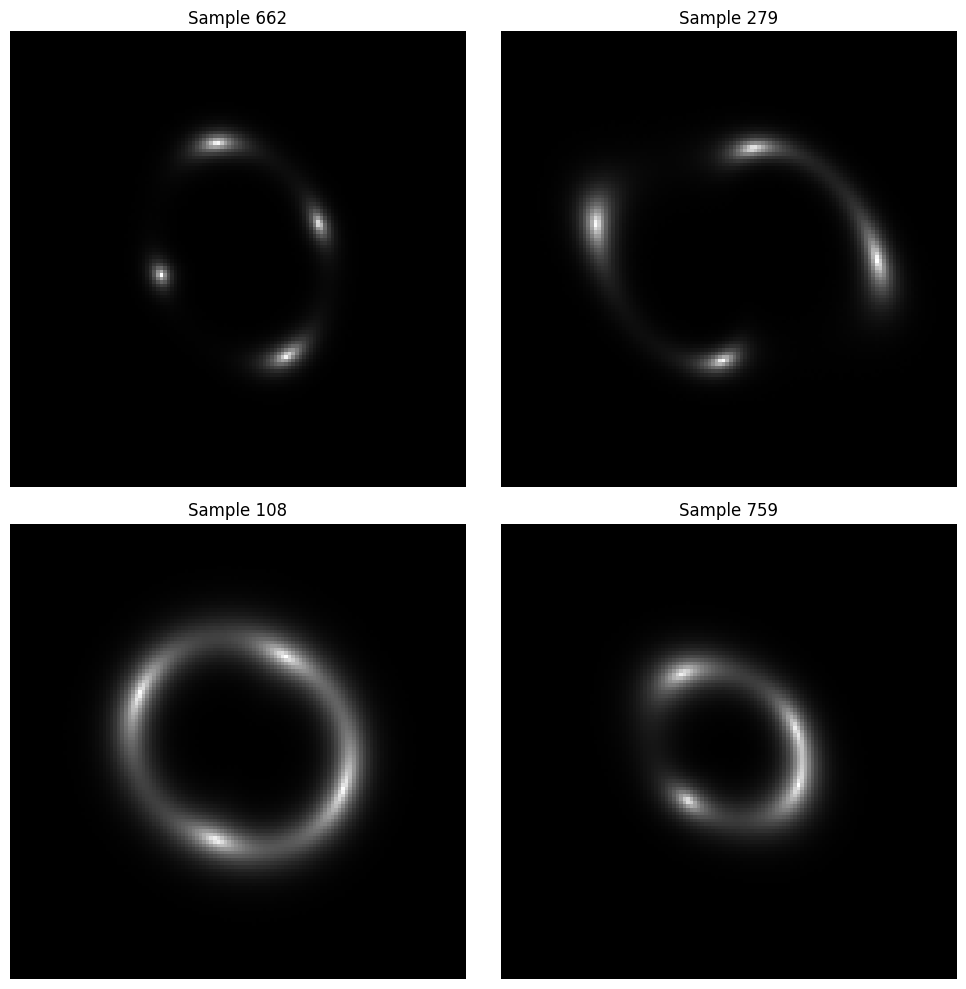

In [6]:
# Visualize a few random samples 
plt.figure(figsize=(6, 6))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# 4 random images
random_indices = np.random.choice(len(dataset), 4, replace=False)
for i, idx in enumerate(random_indices):
    axes[i].imshow(dataset[idx], cmap='gray')
    axes[i].set_title(f'Sample {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Generating anomalous lenses

In [4]:
def generate_anomalous_lens_data(num_images=100, image_size=128, noise_level=0.1):
    """
    Generate a dataset of anomalous gravitational lenses
    
    Parameters:
    -----------
    num_images : int
        Number of anomalous lens images to generate
    image_size : int
        Size of the output images in pixels
    noise_level : float
        Level of Gaussian noise to add
        
    Returns:
    --------
    dataset : list
        List of generated anomalous lens images as numpy arrays
    parameters : list
        List of dictionaries containing the parameters used for each lens
    anomaly_types : list
        List of strings describing the type of anomaly in each image
    """
    
    # Coordinate grid
    delta_pix = 0.05  # pixel scale (arcsec)
    x_grid, y_grid = util.make_grid(numPix=image_size, deltapix=delta_pix)
    
    # Lists w/ generated data
    dataset = []
    parameters = []
    anomaly_types = []
    
    # Define 5 anomaly types (rework later?)
    anomaly_categories = [
        "substructure",        # Additional mass clumps
        "complex_source",      # Multiple or unusual source morphology
        "extreme_parameters",  # Unusual parameter combinations
        "multipole",           # Higher-order lens distortions
        "offset_peaks"         # Misaligned mass and light
    ]
    
    for i in range(num_images):
        # Choose random anomaly type
        anomaly_type = np.random.choice(anomaly_categories)
        anomaly_types.append(anomaly_type)
        
        # Base SIE parameters (main lens)
        einstein_radius = np.random.uniform(1.0, 2.0)  # arcsec
        e1 = np.random.uniform(-0.3, 0.3)  # ellipticity component
        e2 = np.random.uniform(-0.3, 0.3)  # ellipticity component
        center_x = np.random.uniform(-0.1, 0.1)  # arcsec
        center_y = np.random.uniform(-0.1, 0.1)  # arcsec
        
        # External shear parameters
        gamma1 = np.random.uniform(-0.05, 0.05)  # shear component
        gamma2 = np.random.uniform(-0.05, 0.05)  # shear component
        
        # Initialize lens models based on anomaly type
        if anomaly_type == "substructure":
            # Use SIE + SHEAR + SIS for substructure
            lens_model_list = ['SIE', 'SHEAR', 'SIS']
            lens_model = LensModel(lens_model_list=lens_model_list)
            
            # Main lens parameters
            kwargs_lens = [
                {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
                 'center_x': center_x, 'center_y': center_y},  # SIE
                {'gamma1': gamma1, 'gamma2': gamma2}  # SHEAR
            ]
            
            # Add a small SIS substructure
            sub_theta_E = np.random.uniform(0.05, 0.2)  # Small Einstein radius
            sub_center_x = np.random.uniform(-0.5, 0.5)  # Random position
            sub_center_y = np.random.uniform(-0.5, 0.5)
            
            # Add the substructure to the lens model parameters
            kwargs_lens.append({'theta_E': sub_theta_E, 'center_x': sub_center_x, 'center_y': sub_center_y})  # SIS
            
            # Single source model
            source_model_list = ['SERSIC_ELLIPSE']
            source_model = LightModel(light_model_list=source_model_list)
            
            # Regular source
            source_x = np.random.uniform(-0.1, 0.1)
            source_y = np.random.uniform(-0.1, 0.1)
            source_rad = np.random.uniform(0.1, 0.3)
            source_q = np.random.uniform(0.5, 1.0)
            source_phi = np.random.uniform(0, 2*np.pi)
            source_amp = np.random.uniform(50, 100)
            
            kwargs_source = [
                {'R_sersic': source_rad, 'n_sersic': 1, 
                 'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
                 'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
                 'center_x': source_x, 'center_y': source_y, 
                 'amp': source_amp}
            ]
            
        elif anomaly_type == "complex_source":
            # Standard lens model
            lens_model_list = ['SIE', 'SHEAR']
            lens_model = LensModel(lens_model_list=lens_model_list)
            
            kwargs_lens = [
                {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
                 'center_x': center_x, 'center_y': center_y},  # SIE
                {'gamma1': gamma1, 'gamma2': gamma2}  # SHEAR
            ]
            
            # Multiple source components
            source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']
            source_model = LightModel(light_model_list=source_model_list)
            
            # Main source component
            source_x = np.random.uniform(-0.1, 0.1)
            source_y = np.random.uniform(-0.1, 0.1)
            source_rad = np.random.uniform(0.1, 0.3)
            source_q = np.random.uniform(0.5, 1.0)
            source_phi = np.random.uniform(0, 2*np.pi)
            source_amp = np.random.uniform(40, 80)
            source_n = np.random.uniform(1, 4)  # Varying Sersic index
            
            # Secondary source component (nearby)
            source2_x = source_x + np.random.uniform(-0.2, 0.2)
            source2_y = source_y + np.random.uniform(-0.2, 0.2)
            source2_rad = np.random.uniform(0.05, 0.2)
            source2_q = np.random.uniform(0.3, 1.0)
            source2_phi = np.random.uniform(0, 2*np.pi)
            source2_amp = np.random.uniform(20, 60)
            source2_n = np.random.uniform(0.5, 3)
            
            # Third source component (could be more distant)
            source3_x = np.random.uniform(-0.3, 0.3)
            source3_y = np.random.uniform(-0.3, 0.3)
            source3_rad = np.random.uniform(0.05, 0.15)
            source3_q = np.random.uniform(0.3, 1.0)
            source3_phi = np.random.uniform(0, 2*np.pi)
            source3_amp = np.random.uniform(10, 40)
            source3_n = np.random.uniform(0.5, 3)
            
            kwargs_source = [
                {'R_sersic': source_rad, 'n_sersic': source_n, 
                 'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
                 'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
                 'center_x': source_x, 'center_y': source_y, 
                 'amp': source_amp},
                {'R_sersic': source2_rad, 'n_sersic': source2_n, 
                 'e1': (1-source2_q)/(1+source2_q)*np.cos(2*source2_phi),
                 'e2': (1-source2_q)/(1+source2_q)*np.sin(2*source2_phi),
                 'center_x': source2_x, 'center_y': source2_y, 
                 'amp': source2_amp},
                {'R_sersic': source3_rad, 'n_sersic': source3_n, 
                 'e1': (1-source3_q)/(1+source3_q)*np.cos(2*source3_phi),
                 'e2': (1-source3_q)/(1+source3_q)*np.sin(2*source3_phi),
                 'center_x': source3_x, 'center_y': source3_y, 
                 'amp': source3_amp}
            ]
            
        elif anomaly_type == "extreme_parameters":
            # Standard lens model
            lens_model_list = ['SIE', 'SHEAR']
            lens_model = LensModel(lens_model_list=lens_model_list)
            
            # extreme ellipticity or shear
            e1 = np.random.uniform(0.4, 0.7) * np.random.choice([-1, 1])
            e2 = np.random.uniform(0.4, 0.7) * np.random.choice([-1, 1])
            
            # Stronger shear
            gamma1 = np.random.uniform(0.05, 0.15) * np.random.choice([-1, 1])
            gamma2 = np.random.uniform(0.05, 0.15) * np.random.choice([-1, 1])
            
            kwargs_lens = [
                {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
                 'center_x': center_x, 'center_y': center_y},  # SIE with extreme ellipticity
                {'gamma1': gamma1, 'gamma2': gamma2}  # SHEAR with stronger values
            ]
            
            # Single source model
            source_model_list = ['SERSIC_ELLIPSE']
            source_model = LightModel(light_model_list=source_model_list)
            
            # Regular source
            source_x = np.random.uniform(-0.1, 0.1)
            source_y = np.random.uniform(-0.1, 0.1)
            source_rad = np.random.uniform(0.1, 0.3)
            source_q = np.random.uniform(0.3, 0.7)  
            source_phi = np.random.uniform(0, 2*np.pi)
            source_amp = np.random.uniform(50, 100)
            
            kwargs_source = [
                {'R_sersic': source_rad, 'n_sersic': 1, 
                 'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
                 'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
                 'center_x': source_x, 'center_y': source_y, 
                 'amp': source_amp}
            ]
            
        elif anomaly_type == "multipole":
            # Use SIE + SHEAR + MULTIPOLE
            lens_model_list = ['SIE', 'SHEAR', 'MULTIPOLE']
            lens_model = LensModel(lens_model_list=lens_model_list)
            
            # Add multipole perturbation
            m_amp = np.random.uniform(0.01, 0.05)
            m_phi = np.random.uniform(0, 2*np.pi)
            multipole_order = 3  # Use m=3 for trefoil-like distortion
            
            kwargs_lens = [
                {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
                 'center_x': center_x, 'center_y': center_y},  # SIE
                {'gamma1': gamma1, 'gamma2': gamma2},  # SHEAR
                {
                    'm': multipole_order,  # Order of multipole
                    'a_m': m_amp,  # Amplitude
                    'phi_m': m_phi,  # Orientation
                    'center_x': center_x,
                    'center_y': center_y
                }  # MULTIPOLE
            ]
            
            # Single source model
            source_model_list = ['SERSIC_ELLIPSE']
            source_model = LightModel(light_model_list=source_model_list)
            
            # Regular source
            source_x = np.random.uniform(-0.1, 0.1)
            source_y = np.random.uniform(-0.1, 0.1)
            source_rad = np.random.uniform(0.1, 0.3)
            source_q = np.random.uniform(0.5, 1.0)
            source_phi = np.random.uniform(0, 2*np.pi)
            source_amp = np.random.uniform(50, 100)
            
            kwargs_source = [
                {'R_sersic': source_rad, 'n_sersic': 1, 
                 'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
                 'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
                 'center_x': source_x, 'center_y': source_y, 
                 'amp': source_amp}
            ]
            
        else:  # offset_peaks
            # Standard lens model
            lens_model_list = ['SIE', 'SHEAR']
            lens_model = LensModel(lens_model_list=lens_model_list)
            
            kwargs_lens = [
                {'theta_E': einstein_radius, 'e1': e1, 'e2': e2, 
                 'center_x': center_x, 'center_y': center_y},  # SIE
                {'gamma1': gamma1, 'gamma2': gamma2}  # SHEAR
            ]
            
            # Single source model
            source_model_list = ['SERSIC_ELLIPSE']
            source_model = LightModel(light_model_list=source_model_list)
            
            # Offset source far from lens center
            source_x = np.random.uniform(0.3, 0.5) * np.random.choice([-1, 1])
            source_y = np.random.uniform(0.3, 0.5) * np.random.choice([-1, 1])
            source_rad = np.random.uniform(0.1, 0.3)
            source_q = np.random.uniform(0.5, 1.0)
            source_phi = np.random.uniform(0, 2*np.pi)
            source_amp = np.random.uniform(50, 100)
            
            kwargs_source = [
                {'R_sersic': source_rad, 'n_sersic': 1, 
                 'e1': (1-source_q)/(1+source_q)*np.cos(2*source_phi),
                 'e2': (1-source_q)/(1+source_q)*np.sin(2*source_phi),
                 'center_x': source_x, 'center_y': source_y, 
                 'amp': source_amp}
            ]
        
        # Generate lens image
        # Ray-shooting to compute source plane positions
        x_source, y_source = lens_model.ray_shooting(x_grid, y_grid, kwargs_lens)
        
        # Compute surface brightness
        lensed_light = np.zeros_like(x_source)
        
        
        for j in range(len(source_model_list)): # for each source component in the model...
            if j < len(kwargs_source):  # Make sure not out of bounds
                src_light_j = source_model.surface_brightness(x_source, y_source, kwargs_source)
                lensed_light += src_light_j
                break  # full kwargs_list, only need one iteration
        
        # Reshape, add noise
        image = lensed_light.reshape(image_size, image_size)
        noise = np.random.normal(0, noise_level, image.shape)
        image += noise
        
        # Store image and parameters
        dataset.append(image)
        parameters.append({
            'anomaly_type': anomaly_type,
            'einstein_radius': einstein_radius,
            'e1': e1, 'e2': e2,
            'center_x': center_x, 'center_y': center_y,
            'gamma1': gamma1, 'gamma2': gamma2,
            'kwargs_lens': kwargs_lens,
            'kwargs_source': kwargs_source
        })
        
        if i % 10 == 0:
            print(f"Generated {i}/{num_images} anomalous images")
    
    return dataset, parameters, anomaly_types

Generated 0/100 anomalous images
Generated 10/100 anomalous images
Generated 20/100 anomalous images
Generated 30/100 anomalous images
Generated 40/100 anomalous images
Generated 50/100 anomalous images
Generated 60/100 anomalous images
Generated 70/100 anomalous images
Generated 80/100 anomalous images
Generated 90/100 anomalous images
Anomaly types in dataset: {'offset_peaks', 'multipole', 'complex_source', 'extreme_parameters', 'substructure'}


<Figure size 600x600 with 0 Axes>

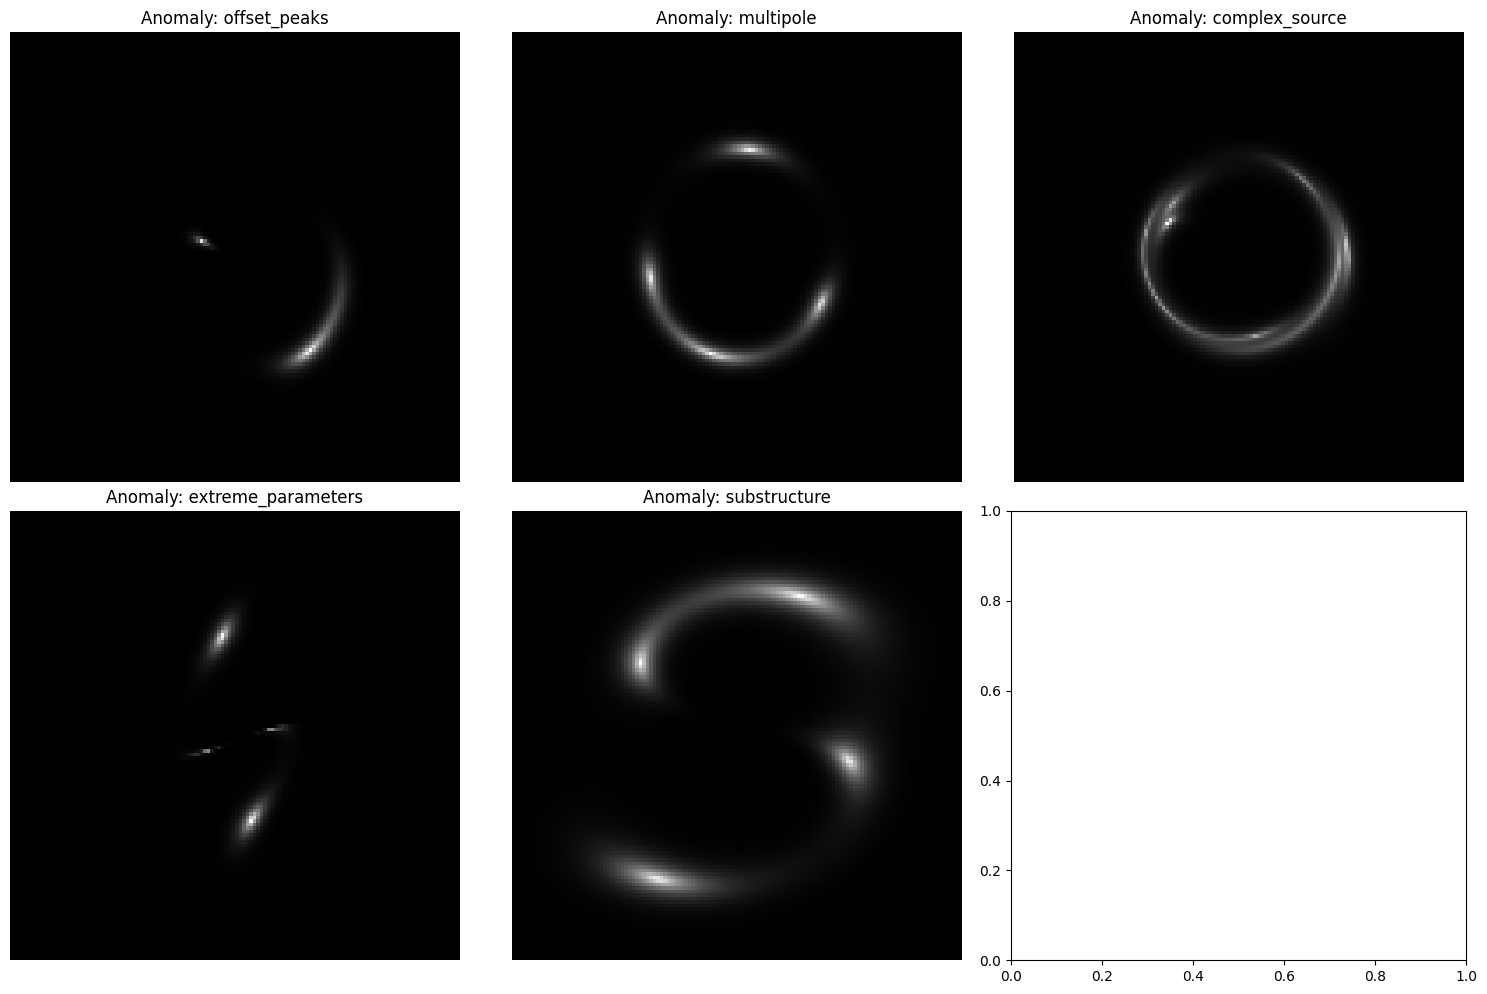

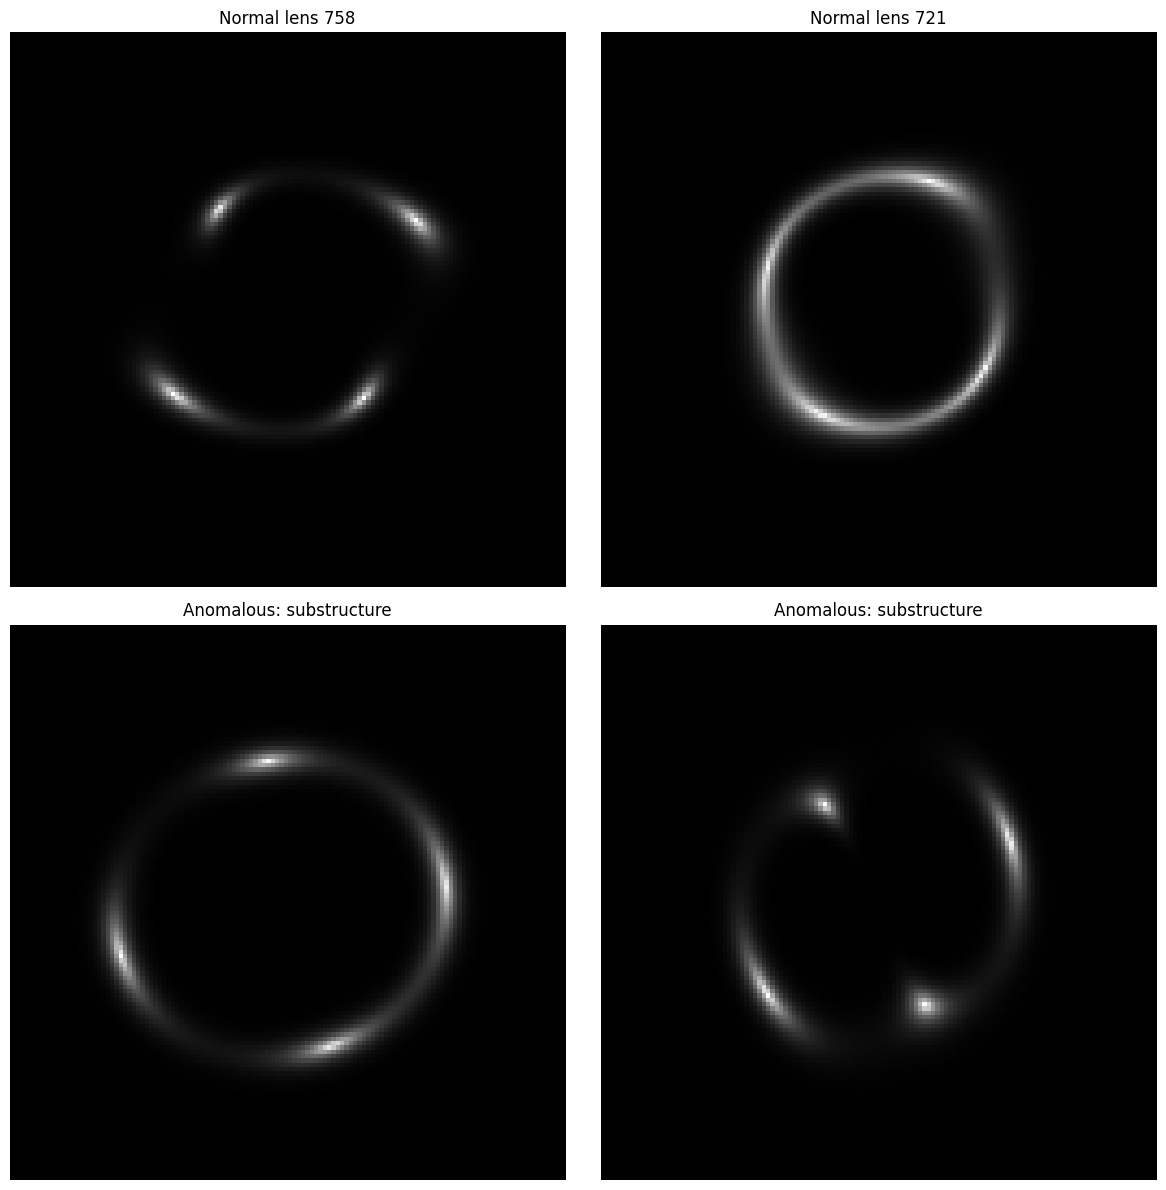

In [7]:
# Dataset of anomalous lenses
n_anomalies = 100
anomalous_dataset, anomalous_parameters, anomaly_types = generate_anomalous_lens_data(n_anomalies)

np.save('anomalous_lens_images.npy', np.array(anomalous_dataset, dtype=np.float32))
np.save('anomalous_lens_parameters.npy', anomalous_parameters)
np.save('anomaly_types.npy', np.array(anomaly_types))

# Visualize random samples
plt.figure(figsize=(6, 6))

# 2x3 grid w/ different anomaly types
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Count unique anomaly types
unique_types = set(anomaly_types)
print(f"Anomaly types in dataset: {unique_types}")

# Try to show one example of each anomaly type
for i, anomaly_type in enumerate(unique_types):
    if i >= len(axes):
        break
    
    # Find an example of this anomaly type
    indices = [j for j, t in enumerate(anomaly_types) if t == anomaly_type]
    if indices:
        idx = np.random.choice(indices)
        axes[i].imshow(anomalous_dataset[idx], cmap='gray')
        axes[i].set_title(f'Anomaly: {anomaly_type}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Compare normal vs anomalous
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# First row: normal lenses
for i in range(2):
    idx = np.random.choice(len(dataset))
    axes[0, i].imshow(dataset[idx], cmap='gray')
    axes[0, i].set_title(f'Normal lens {idx}')
    axes[0, i].axis('off')

# Second row: anomalous lenses
for i in range(2):
    idx = np.random.choice(len(anomalous_dataset))
    axes[1, i].imshow(anomalous_dataset[idx], cmap='gray')
    axes[1, i].set_title(f'Anomalous: {anomaly_types[idx]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()